In [1]:
#use this script to generate the similarity matricies, which can then be used as input into some clustering algorithm to obtain unsupervised clustering 

In [2]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import pandas as pd
from joblib import Parallel, delayed 
import random
from scipy.linalg import sqrtm
import scipy
from numpy import linalg as LA
from numpy.linalg import matrix_power
from sklearn.metrics.cluster import adjusted_rand_score
from srwr.srwr import SRWR

In [3]:
def A_positive(G): 
    
    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == 1]
    G_pos = nx.Graph()
    G_pos.add_nodes_from(G)
    G_pos.add_edges_from(selected_edges)
    A_plus = nx.to_numpy_array(G_pos)
    return A_plus


def A_negative(G): 
    
    selected_edges = [(u,v) for u,v in G.edges if G[u][v]['weight'] == -1]
    G_neg = nx.Graph()
    G_neg.add_nodes_from(G)
    G_neg.add_edges_from(selected_edges)
    A_neg = nx.to_numpy_array(G_neg)

    return A_neg


def graph_checker_deg(G): 
    A_p = A_positive(G)
    A_n = A_negative(G)
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    return np.all(sum_of_rows)

def A_plus(G, bias): 
    
    A_p = bias*A_positive(G)
    A_n = A_negative(G)
    
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    
    normalized_aplus = A_p / sum_of_rows[:, np.newaxis]
    
    return normalized_aplus


def A_neg(G, bias): 
    
    A_p = bias*A_positive(G)
    A_n = A_negative(G)
    
    sum_of_rows = A_p.sum(axis=1) + A_n.sum(axis=1)
    
    normalized_aneg = A_n / sum_of_rows[:, np.newaxis]
    
    return normalized_aneg

#use this function to turn positive and negative values into +/- 1 (good for visualization, or possibly clustering)
def matrix_filter(A, thresh):
    
    n = np.shape(A)[0]
    
    new_mat = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if A[i][j] > thresh:
                new_mat[i][j] = 1
            elif A[i][j] < thresh: 
                new_mat[i][j] = -1
    return new_mat

In [4]:
#weak balance functions

def T_weak(G, n):  
    nodes = np.shape(A_plus(G, 1))[0]
    T = np.block([[A_plus(G, 1), A_neg(G, 1)], [np.zeros((nodes, nodes)), A_plus(G, 1)]])    
    T_weak_n = matrix_power(T, n)
    return T_weak_n

#strong balance functions

def T_strong(G, n): 
    nodes = np.shape(A_plus(G, 1))[0]
    T = np.block([[A_plus(G, 1), A_neg(G, 1)], [A_neg(G, 1), A_plus(G, 1)]]) 
    T_strong_n = matrix_power(T, n) 
    return T_strong_n

In [5]:
#instead of rescaling the vector, put dead walkers back in its original position 
#alpha = 1 is no teleportation 

#this function takes a vector after transitions, and resets lost probability to the original node 
def Rescale_Vector_ResetLost(G, vector_0, vector, alpha):
    v2 = alpha*np.matmul(vector, T_weak(G, 1)) 
    lost_prob = 1 - v2.sum(axis = 1)
    v2_new = vector_0*lost_prob[:, np.newaxis] + v2
    return v2_new
    
#here we sum over all of the vectors representing the different timesteps (length of walks)
#the output gives you the sum over all timesteps 
def Vector_Summed_Steps_ResetLost(G, vector_0, n, alpha):
    v_sum = vector_0
    v_new = vector_0
    
    for i in range(n): 
        v_new = Rescale_Vector_ResetLost(G, vector_0, v_new, alpha)
        v_sum = v_sum + v_new 
        
    return v_sum

#this would give you the vector at step n, after the probabilites have been reset at each timestep 
#you can you this to find the stationary state of the walk as n --> inf 
#the above function is essentially this function summed from n=1 to n=? as you choose 
def Vector_State_ResetLost(G, vector_0, n, alpha):
    v_old = vector_0
    v_new = Rescale_Vector_ResetLost(G, vector_0, v_old, alpha) 
    v_old = v_new
    for i in range(n): 
        v_new = Rescale_Vector_ResetLost(G, vector_0, v_old, alpha)  
        v_old = v_new
    return v_new

In [6]:
#this implements the same thing but for a strong walk (with teleportation parameter alpha)

#this function takes a vector after transitions, and resets lost probability to the original node 
def Vector_Strong_walk(G, vector_0, vector, alpha):
    v2 = alpha*np.matmul(vector, T_strong(G, 1))
    lost_prob = 1 - v2.sum(axis = 1)
    v2_new = vector_0*lost_prob[:, np.newaxis] + v2
    return v2_new
    
#here we sum over all of the vectors representing the different timesteps (length of walks)
#the output gives you the sum over all timesteps 
def Vector_Summed_Steps_Strong_walk(G, vector_0, n, alpha):
    v_sum = vector_0
    v_new = vector_0
    
    for i in range(n): 
        v_new = Vector_Strong_walk(G, vector_0, v_new, alpha)
        v_sum = v_sum + v_new 
        
    return v_sum

#this would give you the vector at step n, after the probabilites have been reset at each timestep 
#you can you this to find the stationary state of the walk as n --> inf 
#the above function is essentially this function summed from n=1 to n=? as you choose 
def Vector_State_Strong_walk(G, vector_0, n, alpha):
    v_old = vector_0
    v_new = Vector_Strong_walk(G, vector_0, v_old, alpha) 
    v_old = v_new
    for i in range(n): 
        v_new = Vector_Strong_walk(G, vector_0, v_old, alpha)  
        v_old = v_new
    return v_new

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 58
Average degree:   7.2500
[[ 0.  1. -1. -1. -1. -1.  0.  0.  0.  0.  0. -1.  0.  0.  1.  1.]
 [ 1.  0. -1.  0. -1. -1.  0.  0. -1. -1.  0.  0.  0.  0.  1.  1.]
 [-1. -1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1. -1. -1.]
 [-1. -1.  1.  0.  0.  0.  1.  1. -1.  0.  1.  1. -1.  0.  0. -1.]
 [ 0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0. -1.  0.  0.]
 [ 0. -1.  0.  0.  1. -1.  0.  0.  0.  1. -1.  0.  1.  0. -1.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1. -1. -1.  0.  1. -1.  0. -1. -1.]
 [-1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0. -1. -1. -1.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  1.  1. -1.  0.  0.  1. -1. -1.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.

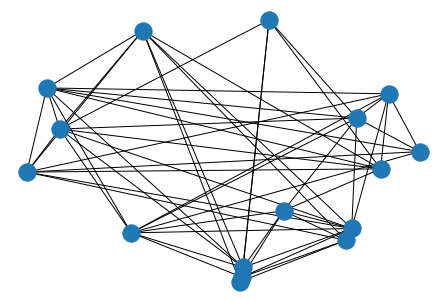

In [7]:
#we will try it on the Highland Tribes dataset - can be obtained from link provided in paper

g = nx.read_edgelist("out.ucidata-gama", data=(('weight', float),),create_using=nx.Graph())
print(nx.info(g))
nx.draw(g)
N = g.number_of_nodes()
A = nx.to_numpy_array(g)
print(A)

g = nx.convert_node_labels_to_integers(g, first_label=0, ordering='default', label_attribute=None)

node_list = np.arange(N)
names_list = ["GAVEV", "KOTUN", "OVE","ALIKA", "NAGAM","GAHUK","MASIL", "UKUDZ", "NOTOH", "KOHIK", "GEHAM", "ASARO", "UHETO", "SEUVE", "NAGAD",
"GAMA"]
names_list_dict = dict(zip(node_list, names_list))

In [8]:
#sort the nodes according to the faction assignment

names_arranged = ["GAVEV", "GAMA", "KOTUN", "NAGAD", "OVE","ALIKA", "GAHUK","MASIL", "UKUDZ",  "GEHAM", "ASARO", "NAGAM","NOTOH","KOHIK","UHETO", "SEUVE"]

co = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

co_sorted = []

for i in names_list: 
    ind = names_arranged.index(i)
    co_sorted.append(co[ind])
print(co_sorted)  

[0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0]


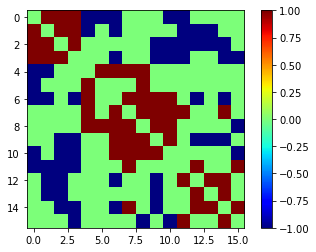

In [9]:
#plot adj matrix ordered by tribe factions

plt.imshow(nx.to_numpy_array(g)[np.argsort(co_sorted), :][:,np.argsort(co_sorted)], cmap=plt.cm.jet)  
plt.colorbar()

1.0


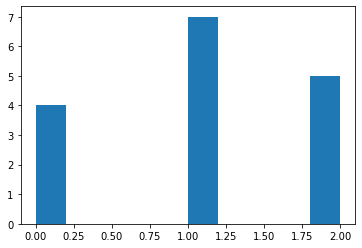

In [10]:
#apply Traag's spinglass method directly to the adjacency matrix to find unsupervised clusters

import igraph as ig
h = ig.Graph.from_networkx(g)
communities = h.community_spinglass(weights = "weight", implementation="neg")

clustering = [set() for i in list(set(communities.membership))]
for i in range(len(communities.membership)):
    clustering[communities.membership[i]].add(i)
plt.hist(communities.membership)
print(adjusted_rand_score(co_sorted, communities.membership))

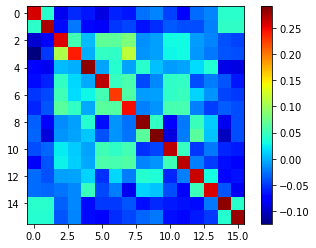

In [11]:
#generate weak walk kernel from 500 steps

G = nx.from_numpy_array(A)

N = 16

vector = np.zeros((N,2*N))
for i in range(N):
    vector[i][i] = 1
    
Walk_Vector = Vector_State_ResetLost(g, vector, 500, 1)
Proximity_Vector = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]
plt.imshow(Proximity_Vector[np.argsort(co), :][:,np.argsort(co)], cmap=plt.cm.jet)  
plt.colorbar()

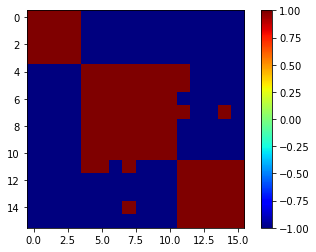

In [12]:
#look at the positive and negative values as +1 or -1 for visualization 
plt.imshow(matrix_filter(Proximity_Vector, 0)[np.argsort(co_sorted), :][:,np.argsort(co_sorted)],cmap=plt.cm.jet)  
plt.colorbar()

1.0


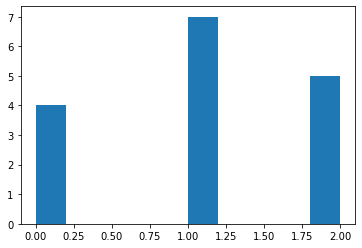

In [13]:
#apply Traag's method directly to the weak walk kernel 

G_prox = nx.from_numpy_array(Proximity_Vector)
h = ig.Graph.from_networkx(G_prox)
communities = h.community_spinglass(weights = "weight", implementation="neg")

clustering = [set() for i in list(set(communities.membership))]
for i in range(len(communities.membership)):
    clustering[communities.membership[i]].add(i)
plt.hist(communities.membership)
print(adjusted_rand_score(co_sorted, communities.membership))

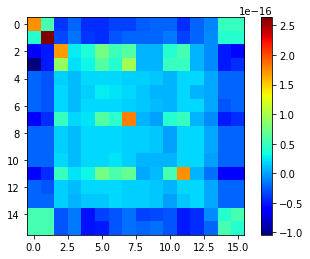

In [14]:
#same for strong balance walk 

G = nx.from_numpy_array(A)

N = 16

vector = np.zeros((N,2*N))
for i in range(N):
    vector[i][i] = 1
    
Walk_Vector = Vector_State_Strong_walk(G, vector, 500, 1)
Proximity_Vector = Walk_Vector[:,0:N] - Walk_Vector[:,N:2*N]
plt.imshow(Proximity_Vector[np.argsort(co), :][:,np.argsort(co)], cmap=plt.cm.jet)  
plt.colorbar()

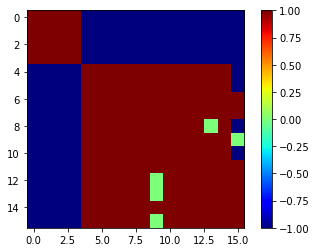

In [15]:
plt.imshow(matrix_filter(Proximity_Vector, 0)[np.argsort(co_sorted), :][:,np.argsort(co_sorted)],cmap=plt.cm.jet)  
plt.colorbar()

0.07494646680942184


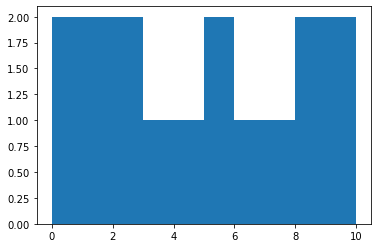

In [16]:
#apply Traag's method directly to the strong balance walk

G_prox = nx.from_numpy_array(Proximity_Vector)
h = ig.Graph.from_networkx(G_prox)
communities = h.community_spinglass(weights = "weight", implementation="neg")

clustering = [set() for i in list(set(communities.membership))]
for i in range(len(communities.membership)):
    clustering[communities.membership[i]].add(i)
plt.hist(communities.membership)
print(adjusted_rand_score(co_sorted, communities.membership))